<a href="https://colab.research.google.com/github/joaovitordeon/ML_diabetes/blob/master/supervisionado_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler


In [0]:
df = pd.read_excel('diabetes_Ex1.xlsx')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 18 columns):
A              768 non-null float64
B              768 non-null float64
C              774 non-null object
D              768 non-null float64
E              768 non-null float64
F              768 non-null float64
G              768 non-null float64
H              768 non-null float64
I              768 non-null float64
J              768 non-null float64
K              768 non-null float64
L              768 non-null float64
M              768 non-null float64
N              768 non-null float64
O              768 non-null float64
P              768 non-null float64
Unnamed: 16    0 non-null float64
Diagnóstico    768 non-null float64
dtypes: float64(17), object(1)
memory usage: 109.2+ KB


*Coluna 'Unnamed: 16' com todos os dados nulos*

In [0]:
df.drop(columns='Unnamed: 16', inplace=True)
df.dropna(inplace=True, axis='index')

In [0]:
df=df.astype(float)

In [0]:
import warnings
warnings.filterwarnings("ignore")

def split_data(clf,features,labels, folds = 10, print_res=False): 
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=folds,random_state=42, test_size=0.25)
    
    #print("Making predictions... \n")
    for train_idx, test_idx in sss.split(features, labels):
        X_train = []
        X_test  = []
        y_train = []
        y_test  = []

        for ii in train_idx:
            X_train.append( features.loc[ii] )
            y_train.append( labels.loc[ii] )
        for jj in test_idx:
            X_test.append( features.loc[jj] )
            y_test.append( labels.loc[jj] )
        
        try:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        except e:
            print(e)
    
    if print_res:
      print('Accuracy', np.round( np.mean(accuracy_scores) ,3) )
      print('Precision', np.round( np.mean(precision_scores) ,3) )
      print('Recall', np.round( np.mean(recall_scores), 3) )
      print('F1-measure', np.round( np.mean(f1_scores), 3) )
    
    return np.round( np.mean(recall_scores), 3)
    

## Knn

In [0]:
# 's' para scaler e 'ws' para without scaler
def knn_func(n):
  recall_s=[]
  recall_ws=[]
  
  X =  df.drop(columns='Diagnóstico')
  y = df['Diagnóstico']
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  X = pd.DataFrame(X)
    
  print("Making predictions... \n")

  for i in range(2,n+1):  
    knn = KNeighborsClassifier(n_neighbors=i)
    #without scale
    recall_s.append( split_data(knn, df.drop(columns='Diagnóstico'), df['Diagnóstico']) )
    #with scale
    recall_ws.append( split_data(knn, X , y))
                 
  plt.plot(range(2,n+1) ,recall_s, color='g')
  plt.plot(range(2,n+1) ,recall_ws , color='orange')
  plt.xlabel('N')
  plt.ylabel('RECALL SCORE')
  plt.xticks(range(2,n+1))
  plt.legend(['without scale', 'with scale'], loc='upper left')
  plt.show()  
        

Making predictions... 



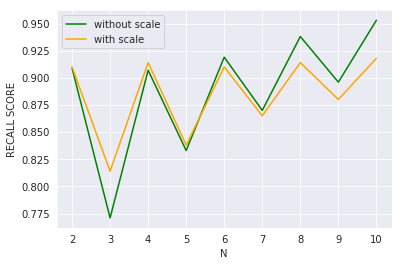

CPU times: user 36.4 s, sys: 147 ms, total: 36.5 s
Wall time: 36.3 s


In [0]:
%%time
knn_func(10)

In [0]:
knn = KNeighborsClassifier(n_neighbors=10)

In [0]:
split_data(knn, df.drop(columns='Diagnóstico'), df['Diagnóstico'], print_res=True)

Accuracy 0.654
Precision 0.663
Recall 0.953
F1-measure 0.782


0.953

## DecisionTree


In [0]:
params={ 'criterion': ['gini', 'entropy'],
         'max_depth' : [2,4,6,8,10] ,
         'min_samples_split': [2,4,6,8,10],
         'min_samples_leaf': [2,4,6,8,10]
       }

In [0]:
dtc = DecisionTreeClassifier(random_state=42)

CV = GridSearchCV( dtc , params, cv=10)
CV.fit(df.drop(columns='Diagnóstico'),df['Diagnóstico'])
print(CV.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [0]:
dtc= DecisionTreeClassifier(**CV.best_params_)

In [0]:
dtc.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [0]:
split_data(dtc, df.drop(columns='Diagnóstico'), df['Diagnóstico'], print_res=True)

Accuracy 0.726
Precision 0.794
Recall 0.788
F1-measure 0.788


0.788

## GaussianNB

In [0]:
#numero de features
l=len(df.columns)-1
l

16

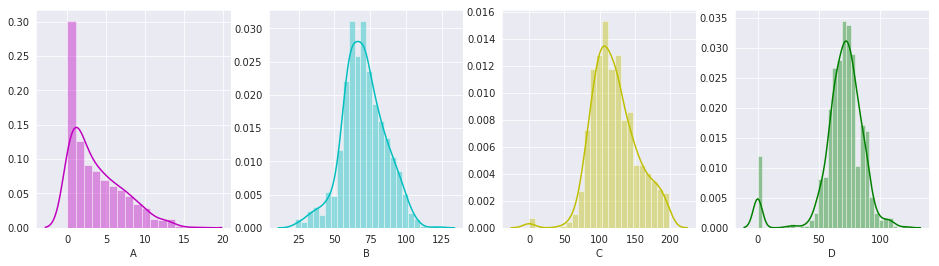

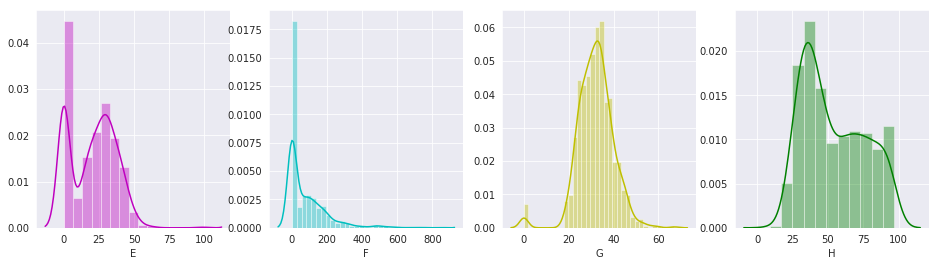

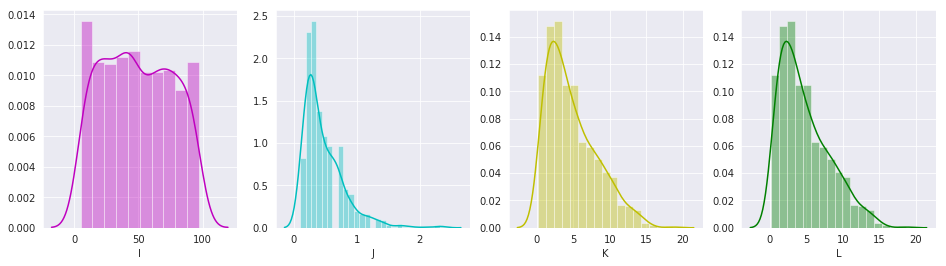

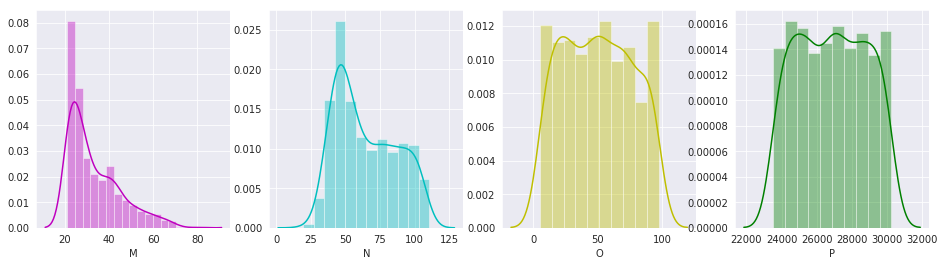

In [0]:
# ver se os dados seguem distribuição normal
sns.set_style("darkgrid")
n=0
for i in range(4):
  fig, ax = plt.subplots(1,4 ,figsize=(16,4))
  sns.distplot(df.iloc[:, n], ax=ax[0], color='m')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[1], color='c')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[2], color='y')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[3], color='g')
  n+=1


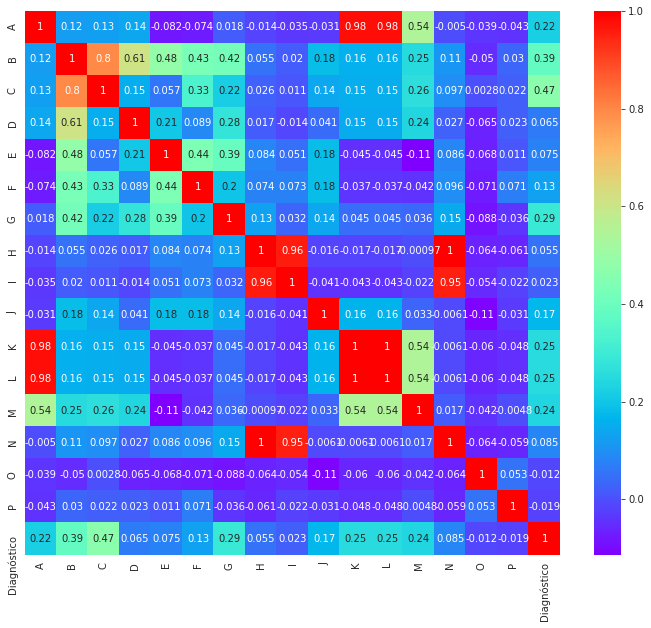

In [0]:
plt.figure(figsize=(12,10))
g = sns.heatmap(df.corr(),annot=True, cmap='rainbow')

In [0]:
gnb = GaussianNB()

In [0]:
#GaussianNB
split_data(gnb, df.drop(columns='Diagnóstico'), df['Diagnóstico'], print_res=True)

Accuracy 0.74
Precision 0.799
Recall 0.803
F1-measure 0.801


0.803

# MLP

In [0]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt


import pandas as pd
import numpy

In [2]:
data_url = 'https://raw.githubusercontent.com/carvalheirafc/deep_learning_stuff/master/neural_networks/diabetes/diabetes_pca_result.csv'

df = pd.read_csv(data_url)

features = df.drop('Diagnóstico', axis = 1)
target = df['Diagnóstico']


print('Data Shape:', features.shape)
print('Labels/Target:', target.shape)
df.describe().transpose()

Data Shape: (768, 4)
Labels/Target: (768,)


,count,mean,std,min,25%,50%,75%,max
Component 1,768.0,-6.693141e-17,1.711960,-5.587340,-1.027072,0.152931,1.095689,5.963579
Component 2,768.0,-6.071532e-17,1.318184,-2.955806,-1.007096,-0.225966,0.959128,3.606582
Component 3,768.0,-3.324887e-17,1.015629,-3.203088,-0.646496,-0.103940,0.549774,4.754503
Component 4,768.0,2.349105e-18,0.966941,-2.192185,-0.664677,-0.115829,0.543242,4.125987
Diagnóstico,768.0,3.489583e-01,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


In [0]:
def create_a_sequential_model(inputs, labels, offset = 1):
  size = ((inputs + labels) // 2 ) * offset 
  network = Sequential()

    
  network.add(Dense(units=size, activation='relu', input_shape=(inputs,), kernel_initializer='random_uniform', bias_initializer='ones'))

    
  network.add(Dense(units=size, activation='relu', input_shape=(inputs,), kernel_initializer='random_uniform', bias_initializer='ones'))
  network.add(Dense(units=1, activation='sigmoid'))
  
  return network

In [0]:
def model_train(model, optimizer, X, y, iterations):
  
  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                      y, 
                                                      test_size=0.33, 
                                                      random_state=63)
  
  cvscores = []
  prediction_acc = []
  
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mse'])
  for it in range(iterations):
    history = model.fit(X_train, y_train, epochs=50, verbose=0)
    scores = model.evaluate(X_test, y_test, verbose=0)
    prediction = model.predict(X_test)
    #print(scores)
    prediction_acc.append((prediction, y_test))
  
  cvscores.append(scores[1] * 100)
  mean_accuracy = numpy.mean(cvscores)
  print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
  
  return mean_accuracy

In [0]:
# With K-fold
def model_train_predict(model, optimizer, seed, X, y, iterations=50):
    cvscores = []
    network = model

    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  
    class_prediction, y_test = [], []
  
    network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
    for train, test in k_fold.split(X, y):
        history = network.fit(X[train], y[train], epochs=iterations, batch_size=10, verbose=2)
  
        scores = network.evaluate(X[test], y[test], verbose=1)
        y_pred = network.predict_classes(X[test])
        class_prediction.append(y_pred)
        y_test.append(y[test])
    
        print(scores)
        cvscores.append(scores[1] * 100)
    
    
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    return history, class_prediction, y_test

### Testing the best parameters

In [0]:
learning = [0.1, 0.001, 0.0001]
offset = [1, 4, 8]
ite = [100, 1000]

scores = []

for it in ite: 
    print('>>> Iteratitons: '+str(it))
    for lr in learning:
        print('>>> Learning Rate: '+str(lr))
        for os in offset:
            print('>>> HiddenLayer Size ' +str((((features.shape[1] + 2) // 2 )* os)))
            sequential_model = create_a_sequential_model(features.shape[1], os)
            sgd_custom = SGD(lr=lr, decay=1e-6, momentum=0.8, nesterov=True)
            acc = model_train(sequential_model, sgd_custom, features, target, it)
            temp_list = [it, lr, os]
            scores.append((temp_list, acc))

>>> Iteratitons: 100
>>> Learning Rate: 0.1
>>> HiddenLayer Size 3
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
74.41% (+/- 0.00%)
>>> HiddenLayer Size 12
71.26% (+/- 0.00%)
>>> HiddenLayer Size 24
70.08% (+/- 0.00%)
>>> Learning Rate: 0.001
>>> HiddenLayer Size 3
73.62% (+/- 0.00%)
>>> HiddenLayer Size 12
74.02% (+/- 0.00%)
>>> HiddenLayer Size 24
74.02% (+/- 0.00%)
>>> Learning Rate: 0.0001
>>> HiddenLayer Size 3
72.83% (+/- 0.00%)
>>> HiddenLayer Size 12
72.83% (+/- 0.00%)
>>> HiddenLayer Size 24
73.62% (+/- 0.00%)
>>> Iteratitons: 1000
>>> Learning Rate: 0.1
>>> HiddenLayer Size 3
75.98% (+/- 0.00%)
>>> HiddenLayer Size 12
74.41% (+/- 0.00%)
>>> HiddenLayer Size 24
66.93% (+/- 0.00%)
>>> Learning Rate: 0.001
>>> HiddenLayer Size 3
74.41% (+/- 0.00%)
>>> HiddenLayer Size 12
72.44% (+/- 0.00%)
>>> HiddenLayer Size 24
72.83% (+/- 0.00%)
>>> Learning Rate: 0.0001
>

In [0]:
# Soring by the max accuracy, and showing the best parameters combination
scores.sort(key= lambda x: x[1], reverse=True)
scores

[([1000, 0.1, 1], 75.98425149917603),
 ([100, 0.1, 1], 74.40944910049438),
 ([1000, 0.1, 4], 74.40944910049438),
 ([1000, 0.001, 1], 74.40944910049438),
 ([100, 0.001, 4], 74.01574850082397),
 ([100, 0.001, 8], 74.01574850082397),
 ([1000, 0.0001, 8], 74.01574850082397),
 ([100, 0.001, 1], 73.62204790115356),
 ([100, 0.0001, 8], 73.62204790115356),
 ([1000, 0.0001, 1], 73.62204790115356),
 ([1000, 0.0001, 4], 73.62204790115356),
 ([100, 0.0001, 1], 72.83464670181274),
 ([100, 0.0001, 4], 72.83464670181274),
 ([1000, 0.001, 8], 72.83464670181274),
 ([1000, 0.001, 4], 72.44094610214233),
 ([100, 0.1, 4], 71.2598443031311),
 ([100, 0.1, 8], 70.07874250411987),
 ([1000, 0.1, 8], 66.92913174629211)]

### Using the best parameters

In [16]:
seed = 666
numpy.random.seed(seed)
sequential_model = create_a_sequential_model(features.shape[1], 1)
sgd_custom = SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=True)
history, predictions, y_t = model_train_predict(sequential_model, sgd_custom, seed, features.values, target.values, 100)

Epoch 1/100
 - 0s - loss: 0.6512 - acc: 0.6512 - mean_squared_error: 0.2290
Epoch 2/100
 - 0s - loss: 0.6454 - acc: 0.6512 - mean_squared_error: 0.2265
Epoch 3/100
 - 0s - loss: 0.6371 - acc: 0.6512 - mean_squared_error: 0.2227
Epoch 4/100
 - 0s - loss: 0.6050 - acc: 0.6512 - mean_squared_error: 0.2080
Epoch 5/100
 - 0s - loss: 0.5755 - acc: 0.6874 - mean_squared_error: 0.1949
Epoch 6/100
 - 0s - loss: 0.5542 - acc: 0.7352 - mean_squared_error: 0.1863
Epoch 7/100
 - 0s - loss: 0.5438 - acc: 0.7294 - mean_squared_error: 0.1825
Epoch 8/100
 - 0s - loss: 0.5384 - acc: 0.7395 - mean_squared_error: 0.1807
Epoch 9/100
 - 0s - loss: 0.5338 - acc: 0.7323 - mean_squared_error: 0.1789
Epoch 10/100
 - 0s - loss: 0.5325 - acc: 0.7381 - mean_squared_error: 0.1785
Epoch 11/100
 - 0s - loss: 0.5302 - acc: 0.7424 - mean_squared_error: 0.1775
Epoch 12/100
 - 0s - loss: 0.5302 - acc: 0.7366 - mean_squared_error: 0.1773
Epoch 13/100
 - 0s - loss: 0.5271 - acc: 0.7323 - mean_squared_error: 0.1765
Epoch 14

In [17]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'mean_squared_error'])


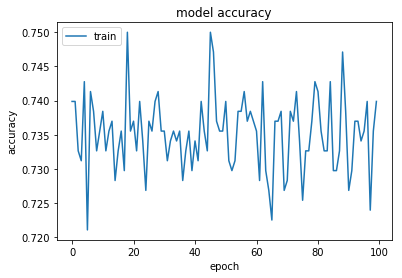

In [18]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

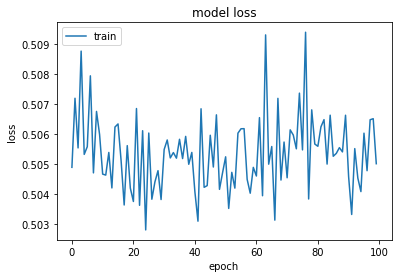

In [19]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()